# Linear Regression

This notebook implements linear regression, a supervised learning technique for predicting numerical values given a set of features. For details on the algorithm, check out the [`README`](https://github.com/kary5678/INDE-577/blob/main/supervised-learning/linear_regression/README.md) in this subdirectory!

---

First, load the relevant libraries needed.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import a nice function for plotting decision boundaries
from mlxtend.plotting import plot_decision_regions

from matplotlib.lines import Line2D

# Import functions from scikit-learn to help with training/testing endeavors
from sklearn.model_selection import train_test_split

# Set the Seaborn theme
sns.set_theme()

## The Data

A linear regression model will be trained using the [Hawks](https://github.com/kary5678/INDE-577/blob/main/Data/hawks.csv) dataset. This dataset contains observations for three species of hawks, and attributes such as age, sex, wing length, body weight, tail length, etc. 

First, I read in the dataset into a pandas DataFrame object, and subset the DataFrame to observations containing no missing values for all the variables of interest. Afterwards, this full dataset will be randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. 
* This process is detailed in Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb), along with other information about the dataset.

In [2]:
# Read in the data and subset it to the relevant columns/observations
hawks = pd.read_csv("../../Data/hawks.csv")
hawks = hawks[["Species", "Age", "Wing", "Weight", "Culmen", "Hallux", "Tail"]].dropna(axis=0)
hawks

,Species,Age,Wing,Weight,Culmen,Hallux,Tail
0,RT,I,385.0,920.0,25.7,30.1,219
2,RT,I,381.0,990.0,26.7,31.3,235
3,CH,I,265.0,470.0,18.7,23.5,220
4,SS,I,205.0,170.0,12.5,14.3,157
5,RT,I,412.0,1090.0,28.5,32.2,230
...,...,...,...,...,...,...,...
903,RT,I,380.0,1525.0,26.0,27.6,224
904,SS,I,190.0,175.0,12.7,15.4,150
905,RT,I,360.0,790.0,21.9,27.6,211
906,RT,I,369.0,860.0,25.2,28.0,207


## Training the model: a custom class

To implement linear regression, I create this custom class with all the necessary functionalities outlined by the algorithm, found in the `README.md` file of this `linear_regression` directory.

In [3]:
class MyLinearRegression:
    """
    A class to fit a linear regression model to data and obtain model diagnostics.

    ...

    Attributes
    ----------
    weights : numpy array (of floats)
        Parameters of the trained models, organized as [w_bias, w_1, w_2, ..., w_n]
    train_errors: list of floats
        Each entry in this list is an error calculated during training iterations
    """
    
    def __init__(self):
        self.weights = None
        self.iterations = 0
        self.train_errors = []
        self.equation = ""
    
    def train(self, X, y, rate=0.05, iterations=1000):
        """
        Train a linear regression model

        Parameters
        ----------
        X: matrix of feature values
        y: array of observed values
        rate (float): learning rate
        iterations (int): number of iterations to train the model for

        Returns: None
        """
        self.iterations = iterations
        n_obs, n_features = X.shape

        # Initialize coefficients/weights and intercept/bias from a uniform distribution
        self.weights = np.random.rand(n_features + 1)
        
        # Implement stochastic gradient decent
        for _ in range(iterations):
            total_error = 0
            for i in range(0, n_obs):
                err = self.predict(X[i,]) - y[i]
                self.weights -= rate * err * np.insert(X[i,], 0, 1)
                total_error += 0.5 * err**2
            self.train_errors.append(total_error / n_obs)
        
        # Format a nice equation to print using the model weights
        self.set_equation()

    def set_equation(self):
        """
        Using the model weights, format a nice equation to print
        """
        eqn = f"y = {self.weights[0]:.3f}"
        for i in range(1, len(self.weights)):
            term = self.weights[i]
            if (np.sign(term) < 0):
                eqn += f" - {abs(term):.3f}x_{i}"
            else:
                eqn += f" + {term:.3f}x_{i}"
        self.equation = eqn

    def plot_train_errors(self):
        """
        Plot the MSE per iteration while the model was being trained
        """
        plt.figure(figsize = (8, 6))
        plt.plot(range(1, self.iterations + 1), self.train_errors)
        plt.xlabel("Iterations")
        plt.ylabel("Mean-squared error")
            
    def predict(self, X):
        """
        Obtain the predicted values given a matrix of features
        """
        X = np.insert(X, 0, 1)
        return np.dot(X, self.weights)



First, I test this class on some sample simulated data.

In [4]:
X = np.array([[1,2], [3,4], [5,6]])
y = np.array([7, 8, 9])

lin_model = MyLinearRegression()
lin_model.train(X, y, 0.01, 1000)

print(lin_model.weights) # prints the model parameters
print(lin_model.equation) # prints the model in equation form

[ 4.12925949 -1.86947259  2.36970827]
y = 4.129 - 1.869x_1 + 2.370x_2


## Model 1: Predicting Weight From Wing Length

As one sees from the scatterplot below, there appears to be a linear relationship between wing length and the weight of a hawk, although it arguably could be better. As wing length increases by 1 mm, there appears to be a linear increase in weight. Thus, a potential linear regression model would be to predict a hawk's weight from their wing length, and this is what will be modeled first.

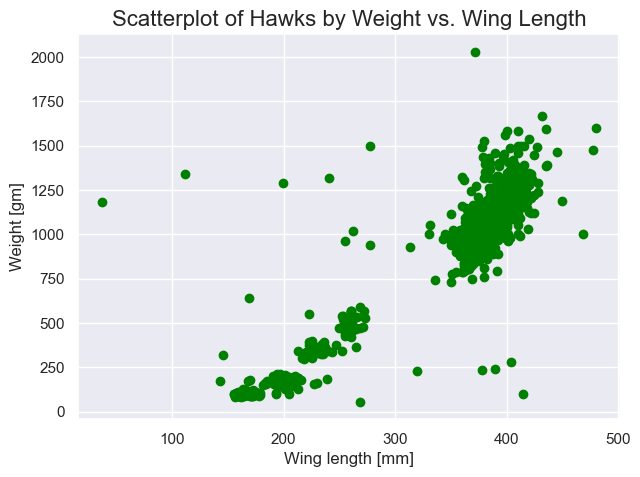

In [5]:
plt.figure(figsize = (7, 5))
plt.scatter(hawks.Wing, hawks.Weight, color = "green")
plt.title("Scatterplot of Hawks by Weight vs. Wing Length", fontsize = 16)
plt.xlabel("Wing length [mm]", fontsize = 12)
plt.ylabel("Weight [gm]", fontsize = 12)
plt.show()

### Splitting the data to train model 1

The processed data is randomly split into a training and testing set using the traditional 80-20 rule of the Pareto Principle. The parameter `random_state=1` is used to ensure that we get the same observations in the training/testing set as in the Hawks exploratory analysis notebook [here](https://github.com/kary5678/INDE-577/blob/main/Data/hawks_analysis.ipynb). We know from the plots in `hawks_analysis.ipynb` that the split using this `random_state` produces a training set that is a good representation for the data being tested (and vice versa).

In [6]:
# Set up predictors matrix (X) and response vector (y)
X = hawks[["Wing"]].to_numpy()
y = hawks["Weight"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Now, I train a linear regression model for the Hawk data to predict tail length from wing length using the class defined previously.

The learning rate of `0.00001` was determined using trial and error. I started off with a learning rate of 0.01, but found that there would be overflow errors. The error calculated at each step of stochastic gradient descent would be too large, causing the weights to fail to converge. I added zeroes to the initial learning rate and increased the number of epochs/iterations until the current learning rate of `0.00001` and `5000` iterations produced satisfactory results.

In [7]:
weight_model = MyLinearRegression()
weight_model.train(X_train, y_train, 0.00001, 5000)

print(weight_model.weights) # prints the model parameters
print(weight_model.equation) # display the equation for the linear line

[-633.30912264    4.31760516]
y = -633.309 + 4.318x_1


The model we have can be written as ...

In the next block of code, I display a scatterplot of tail vs. wing length for both training and testing set, with the linear regression line.

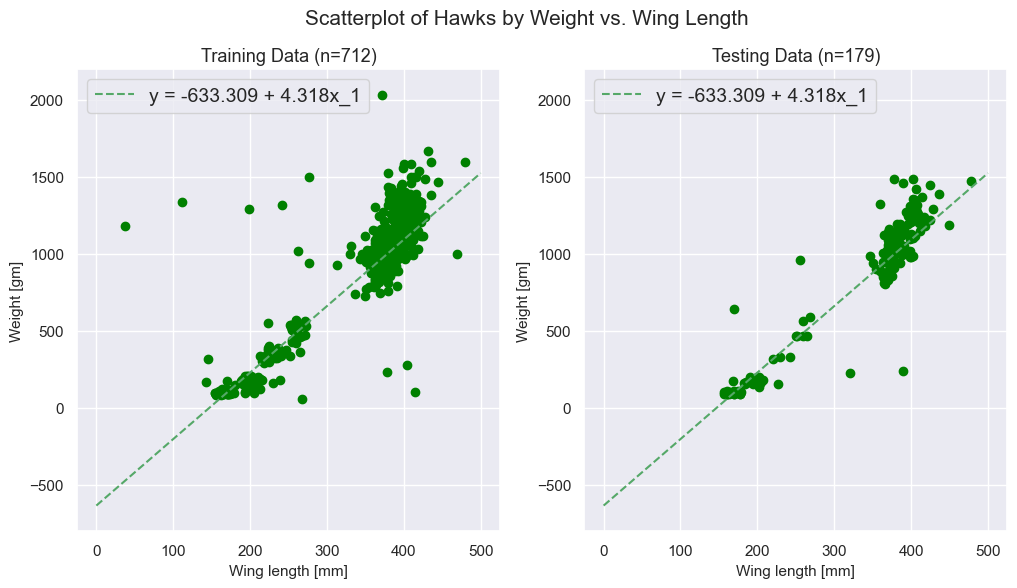

In [9]:
# Obtain the linear regression line
line_x = np.linspace(0, 500, 100)
line_y = weight_model.weights[0] + weight_model.weights[1]*line_x

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Scatterplot of Hawks by Weight vs. Wing Length", fontsize = 15)
# Plot the training set
ax1.set_ylim((-800, 2200))
ax1.scatter(X_train, y_train, color = "green")
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Weight [gm]", fontsize = 11)
ax1.set_title("Training Data (n=712)", fontsize = 13)
ax1.plot(line_x, line_y, '--g', label = weight_model.equation)
ax1.legend(fontsize = 14, loc = "upper left")

# Plot the testing set
ax2.set_ylim((-800, 2200))
ax2.scatter(X_test, y_test, color = "green")
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Weight [gm]", fontsize = 11)
ax2.set_title("Testing Data (n=179)", fontsize = 13)
ax2.plot(line_x, line_y, '--g', label = weight_model.equation)
ax2.legend(fontsize = 14, loc = "upper left")
plt.show()

### Performance/error analysis for model 1

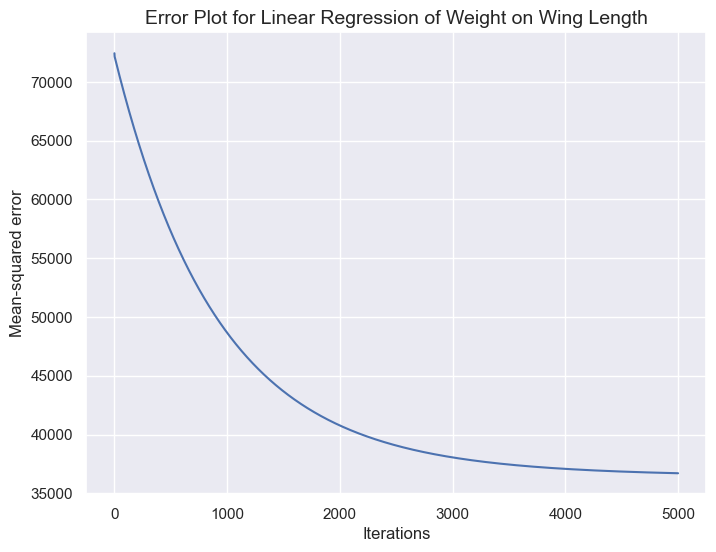

In [10]:
weight_model.plot_train_errors()
plt.title("Error Plot for Linear Regression of Weight on Wing Length", fontsize = 14)
plt.show()

## Model 2: Predicting Weight from Wing, Tail, Hallux, and Culmen Length

Next, we will predict weight from multiple features instead of just the single wing length feature, and compare the performances.

In [11]:
# Set up predictors matrix (X) and response vector (y)
X2 = hawks[["Wing", "Tail", "Hallux", "Culmen"]].to_numpy()
y2 = hawks["Weight"].to_numpy()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=1)

In [12]:
weight_model2 = MyLinearRegression()
weight_model2.train(X_train2, y_train2, 0.00001, 5000)

print(weight_model2.weights) # prints the model parameters
print(weight_model2.equation) # display the equation for the linear line

[-3.98954371e+02  6.75125498e-01 -2.00888621e+00 -1.94383669e-01
  4.16272757e+01]
y = -398.954 + 0.675x_1 - 2.009x_2 - 0.194x_3 + 41.627x_4


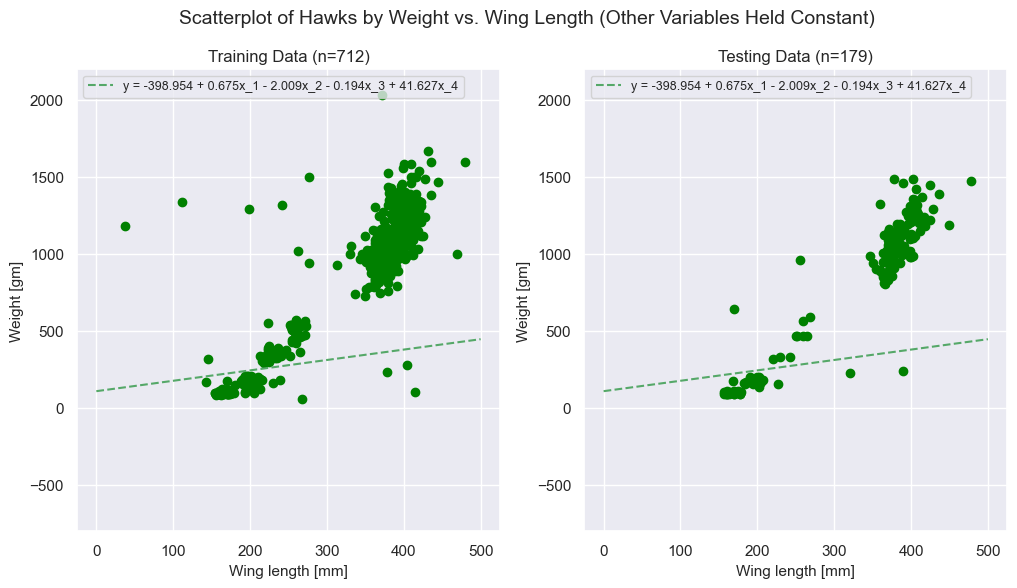

In [13]:
# Obtain the linear regression line
line_y2 = weight_model2.weights[0] + weight_model2.weights[1]*line_x + weight_model2.weights[2]*np.mean(
     X_train2[:, 1]) +  weight_model2.weights[3]*np.mean(X_train2[:, 2]) + weight_model2.weights[4]*np.mean(X_train2[:, 3])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle(f"Scatterplot of Hawks by Weight vs. Wing Length (Other Variables Held Constant)", fontsize = 14)
# Plot the training set
ax1.set_ylim((-800, 2200))
ax1.scatter(X_train2[:, 0], y_train2, color = "green")
ax1.set_xlabel("Wing length [mm]", fontsize = 11)
ax1.set_ylabel("Weight [gm]", fontsize = 11)
ax1.set_title("Training Data (n=712)", fontsize = 12)
ax1.plot(line_x, line_y2, '--g', label = weight_model2.equation)
ax1.legend(fontsize = 9, loc = "upper left")

# Plot the testing set
ax2.set_ylim((-800, 2200))
ax2.scatter(X_test2[:, 0], y_test2, color = "green")
ax2.set_xlabel("Wing length [mm]", fontsize = 11)
ax2.set_ylabel("Weight [gm]", fontsize = 11)
ax2.set_title("Testing Data (n=179)", fontsize = 12)
ax2.plot(line_x, line_y2, '--g', label = weight_model2.equation)
ax2.legend(fontsize = 9, loc = "upper left")
plt.show()

### Performance/error analysis for model 2

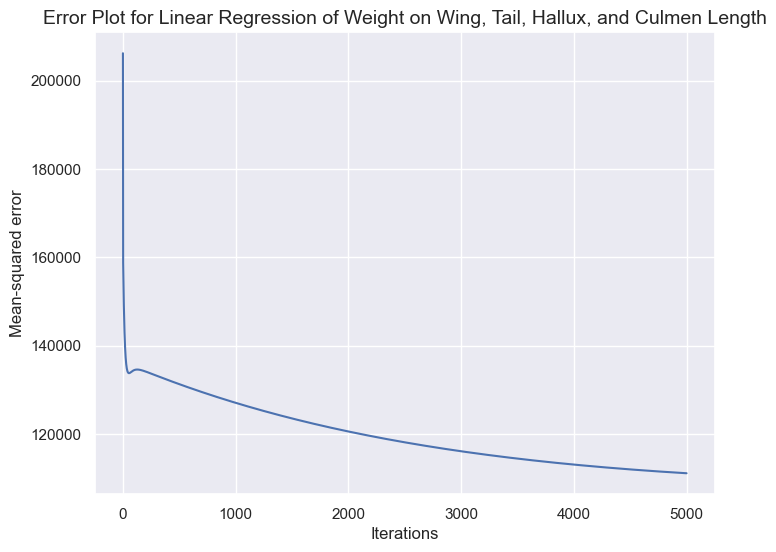

In [14]:
weight_model2.plot_train_errors()
plt.title("Error Plot for Linear Regression of Weight on Wing, Tail, Hallux, and Culmen Length", fontsize = 14)
plt.show()

## Model 3: Linear Regressions for Weight on Wing Length by Species

For fun, I run the linear regression algorithm for each of the three hawk species. I will be using the most simple single predictor model because as previously discussed,  I'm curious whether there will be any different results in terms of slope.

While the correct practice would be to split each species' subset into a training and testing set to train and evaluate the resulting model, the above analysis for model 1 and 2 suggests that the estimated regression line reflects the linear trend in both training and testing set. To keep things succinct, I will just train a model on all the observations for a given species, and evaluate the training error and model weights.

In addition, in practice, you could formulate a single regression line using indicator variables for the three species, but for the purposes of this fux exercise, I am keeping things simple.

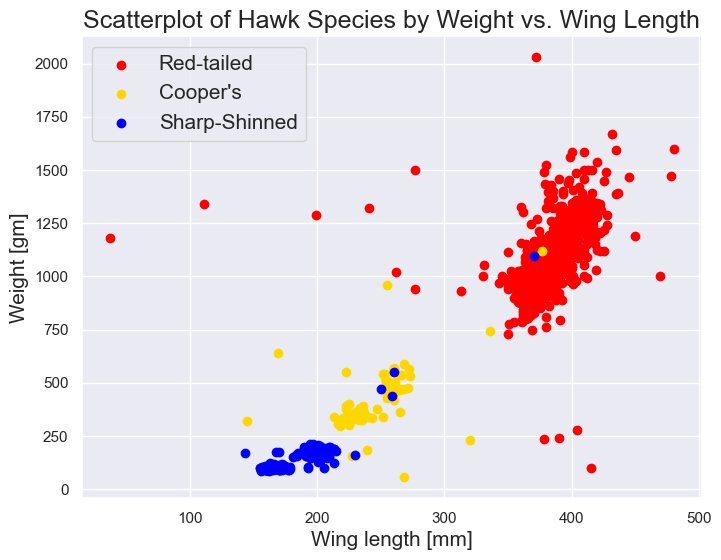

In [15]:
# Produce a scatterplot of tail vs. wing length, color-coded by hawk species
RT = hawks[hawks.Species == "RT"]
CH = hawks[hawks.Species == "CH"]
SS = hawks[hawks.Species == "SS"]

plt.figure(figsize = (8, 6))
plt.scatter(RT.Wing, RT.Weight, color = "red", label = "Red-tailed")
plt.scatter(CH.Wing, CH.Weight, color = "gold", label = "Cooper's")
plt.scatter(SS.Wing, SS.Weight, color = "blue", label = "Sharp-Shinned")
plt.title("Scatterplot of Hawk Species by Weight vs. Wing Length", fontsize = 18)
plt.xlabel("Wing length [mm]", fontsize = 15)
plt.ylabel("Weight [gm]", fontsize = 15)
plt.legend(fontsize = 15, loc = "upper left")
plt.show()

The plot above suggests that the linear relationship between wing length and weight for a hawk may vary depending on the species. For instance, the blue cluster (sharp-shinned hawk) has a flatter slope than the red cluster (red-tailed hawk). Now, we will train a linear regression model for each species to understand the liinear relationships at play.

In [16]:
weight_model_RT = MyLinearRegression()
weight_model_RT.train(np.array(RT.Wing).reshape(-1, 1), np.array(RT.Weight), 0.00001, 5000)

weight_model_CH = MyLinearRegression()
weight_model_CH.train(np.array(CH.Wing).reshape(-1, 1), np.array(CH.Weight), 0.00001, 5000)

weight_model_SS = MyLinearRegression()
weight_model_SS.train(np.array(SS.Wing).reshape(-1, 1), np.array(SS.Weight), 0.00001, 5000)

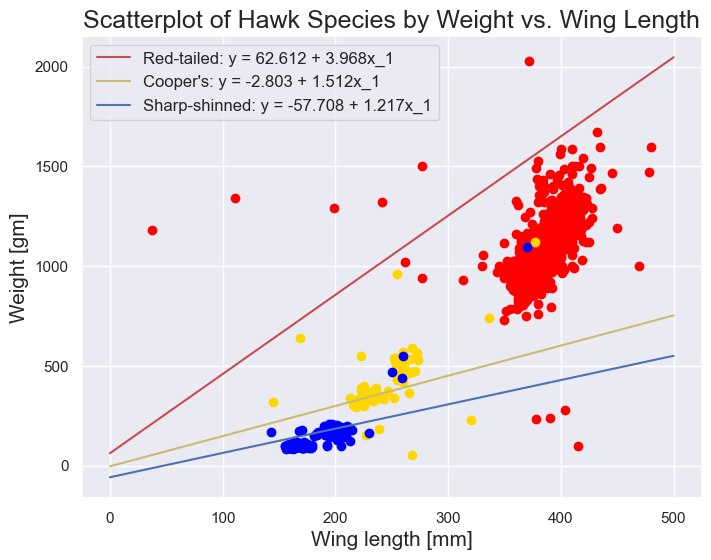

In [17]:
plt.figure(figsize = (8, 6))
plt.scatter(RT.Wing, RT.Weight, color = "red")
plt.scatter(CH.Wing, CH.Weight, color = "gold")
plt.scatter(SS.Wing, SS.Weight, color = "blue")
plt.title("Scatterplot of Hawk Species by Weight vs. Wing Length", fontsize = 18)
plt.xlabel("Wing length [mm]", fontsize = 15)
plt.ylabel("Weight [gm]", fontsize = 15)

x = np.linspace(0,500,100)
#y = tail_model.weights[0] + tail_model.weights[1]*x
plt.plot(x, weight_model_RT.weights[0] + weight_model_RT.weights[1]*x, '-r', label = f"Red-tailed: {weight_model_RT.equation}")
plt.plot(x, weight_model_CH.weights[0] + weight_model_CH.weights[1]*x, '-y', label = f"Cooper's: {weight_model_CH.equation}")
plt.plot(x, weight_model_SS.weights[0] + weight_model_SS.weights[1]*x, '-b', label = f"Sharp-shinned: {weight_model_SS.equation}")
plt.legend(fontsize = 12, loc = "upper left")
plt.show()

The lines actually all look fairly similar on the plot above! An increase in wing length results in a linear increase in tail length regardless of hawk species.

### Performance/error analysis for model 3

### Using scikit-learn

Now, I will briefly set up how you would create a linear regression model using scikit-learn. The methods are much more efficient than the class I wrote, but nevertheless creating the `MyLinearRegression` class allowed for understanding of the inner workings of the algorithm compared to using the blackbox function.

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.intercept_, lin_reg.coef_

(-654.7463120813271, array([4.52180775]))

Recall the results of model 1 trained using `MyLinearRegression` class.

In [20]:
print(weight_model.weights)
print(weight_model.equation)

[-633.30912264    4.31760516]
y = -633.309 + 4.318x_1


The coefficients produced from scikit-learn are comparable to those weights outputted from the trained model!